In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import labtools.statistics

In [2]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'
mpath = '/tmp/sshfs/ampaim/'

In [3]:
# global functions
def rename_df(df, col):
    pairs = [('non-sjogrens sicca','NSS'), ('nss','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]
    for p in pairs:
        df[col] = df[col].replace(p[0],p[1])
    return df

##### Process Mapping Files and Metadata #####

In [41]:
# updated merged fixed dx
df_map = pd.read_csv(path + 'inputs/qiime_mapping_file_20250619.tsv', 
                     sep='\t',
                     index_col=0)

# fix q2 map issues
df_map = df_map.drop('#q2:types')
df_map.index.name = 'SampleID'

# merge with medication data
df_med = pd.read_csv(path + 'inputs/df_med.tsv', 
                     sep='\t',
                     index_col=0)

keep = df_map.index
df_map = pd.concat([df_map, df_med],axis=1)
df_map = df_map.loc[:,~df_map.columns.duplicated(keep='last')].copy()
df_map = df_map.loc[keep,:]

# rename cols
df_map = rename_df(df_map, 'Diagnosis')

# drop all na columns
df_map = df_map.dropna(how='all', axis=1)

print(len(df_map))
df_map.head()

131


,BarcodeSequence,LinkerPrimerSequence,CurrentMTX,HLAB27,MDHAQ,StoolCollected,Together,ContactEmail,ContactName,PrimaryInvestigator,...,RFpos,Batch,EverTreated,Medication,DiseaseActive,AgeAtVisit,shannon_entropy,sum,Medication_Status,Medication_Status2
SampleID,,,,,,,,,,,,,,,,,,,,,
518-0-twin-psa-plate308,AGCCCTGCTACA,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,NaN,CDP,NaN,NaN,NaN,NaN,6.030713,0.0,NoMed,Untreated
524-0-twin-psa-plate308,AGTAAAGATCGT,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,NaN,CDP,NaN,NaN,NaN,NaN,4.032749,0.0,NoMed,Untreated
525-0-twin-psa-plate308,TTGCTGGACGCT,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,NaN,CDP,NaN,NaN,NaN,NaN,5.477343,0.0,NoMed,Untreated
528-0-twin-psa-plate308,CCTAACGGTCCA,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,NaN,CDP,NaN,NaN,NaN,NaN,4.221301,0.0,NoMed,Untreated
529-0-twin-psa-plate308,TTCCTTAGTAGT,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,NaN,CDP,NaN,NaN,NaN,NaN,3.963222,0.0,NoMed,Untreated


In [40]:
# disease breakdown by sample numbers
df_map['Diagnosis'].value_counts()

Diagnosis
RA         43
PsO        28
PsA        28
NSS        11
SjD        10
Healthy     6
SLE         5
Name: count, dtype: int64

In [83]:
# metrics of disease severity and clinical metadata
# batch effect of 'Project'?
covariates = [
    # 'HLAB27', # 12 have 0, rest NA
    'Hispanic',
    'ProbioticsInPast1mo',
    'ProbioticsInPast3Months', 
    'Race',     
    # 'Ethnicity', # 22 not hispanic or latino, rest NA
    'ICDCode', 
    'IllnessNotes', 
    'Age', 
    'Sex'
]
medication = [
    # 'CurrentBiologics', # 94 have 0, rest NA
    'CurrentIntralesionalSteroids',
    # 'CurrentMTX', # 83 have 0, rest NA
    # 'CurrentOtherDMARDs', # 93 have 0, rest NA
    'CurrentParenteralSteroids',
    'CurrentTopicalSteroids',
    'CurrentUV', # what is this?
    'DrugNaive',
    'HxBiologics',
    # 'HxOtherDMARDs', # 75 have 0, rest NA
    'hxMTX',
    'hxParenteralSteroids',
    'AbxInPast3Months', 
    'EverTreated',
    'Medication'
]
disease_severity = [
    'BSA',
    'BSASeverityByBSA',
    'CRP',    
    'DAS28', 
    'Dactylitis', 
    'DiseaseDuration',
    'ESR', 
    'Enthesitis',    
    # 'MDHAQ', # RA score; 1 has 1, rest NA
    'PhysicianGlobalPsA',
    'PsAtype',
    'PsOtype',
    'RAPID3', # RA score    
    'SJC', 
    'TJC',
    'CCPpos',
    'Disease', 
    'DiseaseDurationYears',
    'RFpos',
    'DiseaseActive'
]
disease_severity_qual = [
    'BSASeverityByBSA',
    'Dactylitis', 
    'Enthesitis',    
    'PsAtype',
    'PsOtype',
    'CCPpos',
    'Disease', 
    'RFpos',
    'DiseaseActive'
]
disease_severity_quant = [
    'BSA',
    'CRP',    
    'DAS28', 
    'DiseaseDuration',
    'ESR', 
    # 'MDHAQ', # RA score; 1 has 1, rest NA
    'PhysicianGlobalPsA',
    'RAPID3', # RA score    
    'SJC', 
    'TJC',
    'DiseaseDurationYears',
]
# print(df_map.columns.values)

# test how many of these variables have >1 unique value
for i in disease_severity + medication + covariates:
    if len(df_map[i].value_counts()) == 1:
        print(i)
        print(df_map[i].value_counts())
   
print('Done')

Done


##### Alpha Diversity #####

KruskalResult(statistic=11.728243423628555, pvalue=0.06831330957416619)


Diagnosis
RA         44
PsO        28
PsA        28
SjD        11
NSS         9
Healthy     6
SLE         5
Name: count, dtype: int64

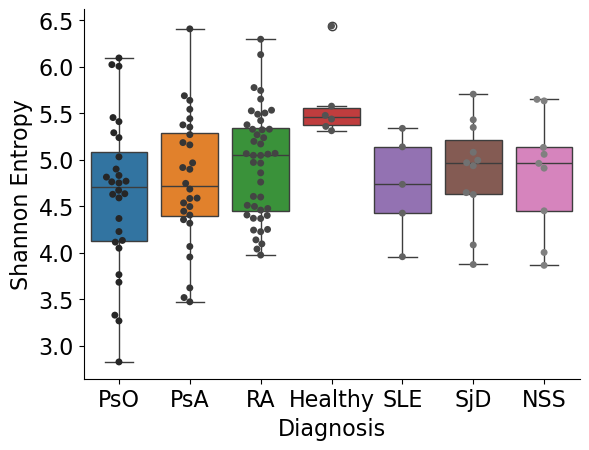

In [30]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'outputs/jobs52/Analysis_core_pipeline_taxonomic_0/diversity/shannon_entropy_metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# rename dx
df_alpha = rename_df(df_alpha, 'Diagnosis')

# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), 
                          nan_policy='propagate', 
                          axis=0, 
                          keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', hue='Diagnosis')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


KruskalResult(statistic=1.7340169992609162, pvalue=0.18789870156697303)


Diagnosis
RA         44
PsO        28
PsA        28
SjD        11
NSS         9
Healthy     6
SLE         5
Name: count, dtype: int64

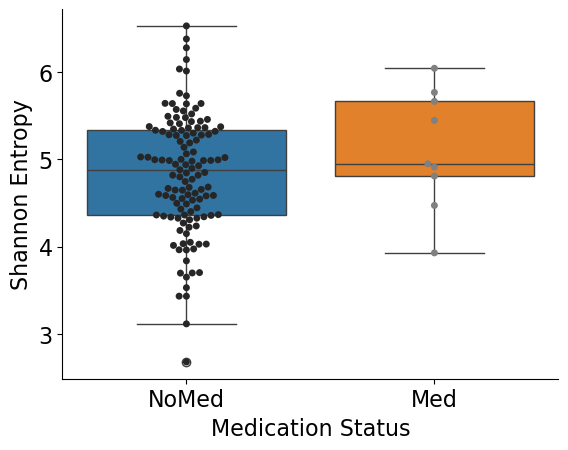

In [45]:
# plot medication alpha div
                                                         
# KW test
print(scipy.stats.kruskal(*list(df_map.groupby('Medication_Status')['shannon_entropy'].apply(list).values), 
                          nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_med, x='Medication_Status', y='shannon_entropy', hue='Medication_Status')
sns.swarmplot(data=df_med, x='Medication_Status', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Medication Status",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


##### Table 1 #####

In [47]:
# for table 1 for presentation
t1_meta = ['Age','Sex','Weight','Diagnosis','Medication','Hispanic','Race','mtx', 
           'Ethnicity','CurrentBiologics','CurrentOtherDMARDs','HxBiologics','HxOtherDMARDs',
           'hcq','Medication_Status']
# df_med['Medication_Status'].value_counts()

# filter on relevant metadata vars

# df_t1 = df_med[t1_meta]
df_t1 = df_map[t1_meta]


# drop col that are all na
df_t1 = df_t1.dropna(axis=1, how='all')
 
# create a new column that is a mix of Race and Hispanic, where everything is to lower
# black_white is black
# white and hispanic -> hispanic
# white and not hispanic -> caucasian 
df_t1['Race'] = df_t1['Race'].replace(np.nan,'nan')
df_t1['Race'] = df_t1['Race'].apply(lambda x: x.lower())
df_t1['Race'] = df_t1['Race'].replace('black_white','nan')

# new function to label per row
def label_race(row):
   if row['Hispanic'] == '1.0':
      return 'hispanic'
   else:
       return row['Race']

df_t1['Final_Ethnicity'] = df_t1.apply(label_race, axis=1)

# rename dx
df_t1 = rename_df(df_t1, 'Diagnosis')

df = df_t1.copy()

# order of variables will be
'''
n
Age (years)
Sex (M/F)
Ethnicity
Hispanic
Caucasian
Black
Asian
Medication (Y/N)
MTX
HCQ
Other DMARDs
Current Biologics
Hx of Biologics
Hx of Other DMARDs
'''

ns = []
ages = []
genders = []
#sex_F = []
#sex_M = []
# sex_order = ['F','M']
# ethnicities = []
# ethnicity_order = ['hispanic','caucasian','black','asian']
ethnicity_hispanic = [] 
ethnicity_caucasian = [] 
ethnicity_black = []
ethnicity_asian = []

medications = []
med_order = ['mtx','hcq','CurrentOtherDmards','CurrentBiologics','HxBiologics','HxOtherDMARDs']

# for every column in table 1 (i.e. healthy, affected, then each disease individually)
dfs = {
    'Healthy': 'placeholder',
    'Affected': df_t1[df_t1['Diagnosis'] != 'Healthy']
}

# sets order in table
dx = ['Healthy', 'RA', 'PsO', 'PsA', 'SLE', 'SjD', 'NSS']

for d in dx:
    dfs[d] = df_t1[df_t1['Diagnosis'] == d]

col_vals = {}

for d in dfs:
    print(d)
    col_entries = [d]

    # grab relevant df
    df = dfs[d]

    # get n samp
    n = len(df)    
    ns.append(n)
    col_entries.append(n)
    
    # for continuous vars, get a CI
    for f in ['Age']:
        X = df[f].astype(float)
        
        # drop na
        X = X.dropna()

        # get mean age
        confidence_level = 0.95
        mean = np.round(np.nanmean(X),1)

        sem = scipy.stats.sem(X)
        ci = scipy.stats.t.interval(confidence_level, len(X) - 1, loc=mean, scale=sem)
        str_ci = str(mean) + ' (' + str(np.round(ci[0],1)) + ', ' + str(np.round(ci[1],1)) + ')'

        # mean age and sd
        if np.isnan(sem):
            str_age = str(mean) + ' (NA)'
        else:
            str_age = str(mean) + ' (' + str(np.round(sem,1)) + ')'
        col_entries.append(str_age)
        #if np.isnan(mean): 
        #    col_entries.append('NA')
        #elif np.isnan(ci[0]):           
        #    col_entries.append(str(mean) + ' (NA, NA)')
        #else:            
        #    ages.append(str_ci)
        #    col_entries.append(str_ci)


    # sex_order = ['F','M']
    n_F, n_M = len(df[df['Sex'] == 'F']),len(df[df['Sex'] == 'M'])
    gender_percent = int(np.round(n_F / (n_F + n_M)*100, 0))
    gender_str = str(len(df[df['Sex'] == 'F'])) + ' (' + str(gender_percent) + '%)'  
    
    # genders.append(gender_tuple)
    col_entries.append(gender_str)

    # add title
    col_entries.append('')

    # get n per ethnicity
    for e in ['hispanic', 'white', 'black', 'asian']:
        sub_df = df.dropna(how='any', subset='Final_Ethnicity')
        
        n_e = len(sub_df[sub_df['Final_Ethnicity'] == e])
        n_total = len(sub_df)

        eth_percent = int(np.round(n_e / (n_total)*100, 0))
        eth_str = str(n_e) + ' (' + str(eth_percent) + '%)'  
        col_entries.append(eth_str)

    # 
    # ethnicity_order = ['hispanic','caucasian','black','asian']
    # gemder_tuple
    ethnicities = []
    medications = []
    col_entries.append('')
    # med_order = ['mtx','hcq','CurrentOtherDMARDs','CurrentBiologics','HxBiologics','HxOtherDMARDs']
    med_order = ['mtx','hcq','HxBiologics']
    for m in med_order:
        sub_df = df.dropna(how='any', subset=m)

        n_m = len(sub_df[sub_df[m] == 1])
        n_total = len(sub_df)

        if n_total == 0:
            col_entries.append('NA')

        else:
            med_percent = int(np.round(n_m / (n_total)*100, 0))
            med_str = str(n_m) + ' (' + str(med_percent) + '%)'  

            col_entries.append(med_str)

    
    # for categorical vars, get a value_counts
    #for f in ['Diagnosis','CurrentBiologics']: #,'Diagnosis', 'Ethnicity', 'Medication']
    #    print(df[f].value_counts(dropna=False))

    # each column is: Diagnosis, n, Age, Gender_tuple, Ethnicity(title), Hispanic, Caucasian, Black, Asian, Medication (title), then med order
    col_vals[d] = col_entries

df_final_t1 = pd.DataFrame.from_dict(col_vals)
df_final_t1.index = ['Diagnosis', 'n', 'Age (s.d.)', 'Female (%)', 'Ethnicity', 'Hispanic', 'Caucasian', 'Black', 'Asian',
                     'Medication', 'MTX','HCQ','HxBiologics']

df_final_t1.to_csv(path + 'outputs/jobs27/df_final_t1.csv')
df_final_t1


Healthy
Affected
RA
PsO
PsA
SLE
SjD
NSS


,Healthy,Affected,RA,PsO,PsA,SLE,SjD,NSS
Diagnosis,Healthy,Affected,RA,PsO,PsA,SLE,SjD,NSS
n,6,125,43,28,28,5,10,11
Age (s.d.),43.0 (1.9),47.7 (1.2),46.8 (2.0),49.2 (2.2),44.6 (2.5),32.0 (NA),49.4 (5.4),54.9 (4.0)
Female (%),4 (67%),91 (73%),37 (86%),17 (61%),11 (39%),5 (100%),10 (100%),11 (100%)
Ethnicity,,,,,,,,
Hispanic,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),0 (0%)
Caucasian,4 (67%),104 (83%),32 (74%),27 (96%),25 (89%),2 (40%),7 (70%),11 (100%)
Black,0 (0%),7 (6%),5 (12%),0 (0%),0 (0%),2 (40%),0 (0%),0 (0%)
Asian,2 (33%),10 (8%),4 (9%),0 (0%),3 (11%),1 (20%),2 (20%),0 (0%)
Medication,,,,,,,,


##### Beta Div #####

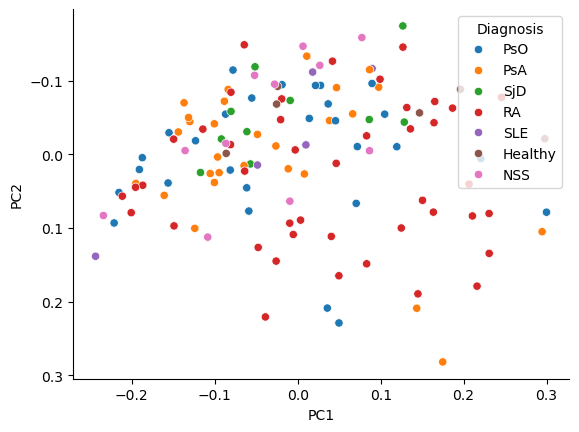

In [59]:
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'outputs/jobs52/Analysis_core_pipeline_taxonomic_0/diversity/unweighted_ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
#df_pc = df_pc.set_index('131-slesjo-plate308') 
df_pc = df_pc.set_index(df_pc.columns[0]) 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['131-slesjo-plate308'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_map], axis=1)

df_pc.to_csv(path + 'outputs/jobs27/unweighted_pcoa.tsv', sep='\t')

# plot
sns.scatterplot(x='PC1',y='PC2',hue='Diagnosis',data=df_pc)
sns.despine()

##### PiCRUSt2 #####

In [62]:
# PICRUST2
# don't forget to uncompress path_abun_unstrat.tsv.gz
# 393 columns/pathways represented here
df_path = pd.read_csv(path + 'outputs/jobs52/Analysis_lefse_picrust2_0/tables/picrust2_briteko.tsv',
                      sep='\t',
                      index_col=0).T

KO_names = list(df_path.columns.values)

# normalize by row total (per sample basis)
df_path = df_path.div(df_path.sum(axis=1), axis=0)
df_path.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

df_path.head()

OTU ID,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Genetic Information Processing|Transcription|Spliceosome,Human Diseases|Infectious disease: bacterial|Bacterial invasion of epithelial cells,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Biosynthesis of other secondary metabolites|Caffeine metabolism,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
131-slesjo-plate308,0.190208,0.040522,0.002644,0.003125,0.009964,0.000255,0.035558,0.000257,0.031789,0.000022,...,0.000042,2.193680e-07,0.000014,0.000007,0.000000e+00,0.0,9.731961e-07,0.0,5.982763e-07,0.0
209-pso-plate307,0.200580,0.044446,0.002669,0.003431,0.010211,0.000244,0.036018,0.000295,0.033634,0.000024,...,0.000090,0.000000e+00,0.000008,0.000005,0.000000e+00,0.0,0.000000e+00,0.0,2.827505e-06,0.0
235-psa-plate307,0.196962,0.046194,0.003038,0.003514,0.011020,0.000281,0.035035,0.000247,0.034017,0.000012,...,0.000062,0.000000e+00,0.000003,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,1.173423e-06,0.0
240-psa-plate307,0.197579,0.043630,0.002768,0.003439,0.010244,0.000208,0.035401,0.000226,0.033188,0.000017,...,0.000096,1.326378e-07,0.000000,0.000000,0.000000e+00,0.0,9.815194e-07,0.0,3.846495e-06,0.0
241-pso-plate307,0.193910,0.032761,0.002644,0.003829,0.009013,0.000165,0.038584,0.000256,0.032997,0.000002,...,0.000005,8.452403e-08,0.000012,0.000007,8.452403e-07,0.0,0.000000e+00,0.0,1.479170e-07,0.0


##### Taxa tables #####

In [74]:
# create taxa tables, they come with metadata 
L_to_otu = {}
levels = [6]
L_to_spec_otu = {}

# build dict of otu tables
for l in levels:
    # construct key
    level = 'L' + str(l)

    # read in df otu
    df_taxa = pd.read_csv(path + 'outputs/jobs52/Analysis_core_pipeline_taxonomic_0/tables/taxa_table_L' + str(l) + '.tsv', 
                          index_col=0,
                          sep='\t').T
    
    # determine columns to drop; i.e. keep taxa only
    dropcol = []
    for c in list(df_taxa.columns.values):
        if c[0:3] != 'd__':
            dropcol.append(c)
            
    df_taxa = df_taxa.drop(dropcol, axis=1)
    df_taxa.to_csv(path + 'inputs/counts_L' + str(l) + '.csv')
    
    # normalize the cols
    df_taxa = df_taxa.div(df_taxa.sum(axis=1), axis=0)
    df_taxa.to_csv(path + 'inputs/otu_table_L' + str(l) + '.csv')

df_taxa.head()

OTU ID,d__Archaea;p__Methanobacteriota_A_1229;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter_A,d__Archaea;p__Methanobacteriota_A_1229;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera,d__Archaea;p__Thermoplasmatota;c__Thermoplasmata_1773;o__Methanomassiliicoccales;f__Methanomethylophilaceae;g__UBA71,d__Bacteria;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Pauljensenia,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Peptidiphaga,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Varibaculum,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Bifidobacteriaceae;g__Alloscardovia,...,d__Bacteria;p__Spirochaetota;c__Spirochaetia;o__Treponematales;f__Treponemataceae;g__Treponema_D,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Dethiosulfovibrionaceae;g__Pyramidobacter,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus,d__Bacteria;p__Verrucomicrobiota;c__Kiritimatiellae_777934;o__RFP12;f__UBA1067;g__Spyradenecus,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__UBA1829;g__UBA11452,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__UBA1829;g__UBA1732,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Opitutales;f__CAG-312;__,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Opitutales;f__CAG-312;g__Merdousia,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia
131-slesjo-plate308,0.000000,0.0,0.0,0.015836,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.114119
209-pso-plate307,0.000000,0.0,0.0,0.015516,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
235-psa-plate307,0.000000,0.0,0.0,0.006313,0.0,0.0,0.000421,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243498
240-psa-plate307,0.000000,0.0,0.0,0.000381,0.0,0.0,0.000381,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076671
241-pso-plate307,0.366338,0.0,0.0,0.017619,0.0,0.0,0.001025,0.0,0.000158,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


##### Merge df analysis #####

In [78]:
# merge dataframes
df_merge = pd.concat([df_map, 
                      df_alpha['shannon_entropy'],
                      df_pc[['PC1','PC2']],
                      df_taxa, 
                      df_path],
                     axis=1)
df_merge.head()

,BarcodeSequence,LinkerPrimerSequence,CurrentMTX,HLAB27,MDHAQ,StoolCollected,Together,ContactEmail,ContactName,PrimaryInvestigator,...,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Genetic Information Processing|Transcription|Spliceosome,Human Diseases|Infectious disease: bacterial|Bacterial invasion of epithelial cells,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Biosynthesis of other secondary metabolites|Caffeine metabolism,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
518-0-twin-psa-plate308,AGCCCTGCTACA,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,0.000019,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,7.689980e-07,0.0
524-0-twin-psa-plate308,AGTAAAGATCGT,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,0.000007,0.0,1.974425e-07,1.269273e-07,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0
525-0-twin-psa-plate308,TTGCTGGACGCT,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,0.000034,0.0,1.770992e-06,1.046495e-06,0.0,0.0,1.502659e-07,0.0,2.110879e-06,0.0
528-0-twin-psa-plate308,CCTAACGGTCCA,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,0.000004,0.0,4.769190e-06,7.705372e-07,0.0,0.0,4.938175e-06,0.0,0.000000e+00,0.0
529-0-twin-psa-plate308,TTCCTTAGTAGT,CCGGACTACHVGGGTWTCTAAT,0.0,NaN,NaN,1.0,NaN,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,...,0.000008,0.0,2.175505e-05,1.276353e-05,0.0,0.0,4.663682e-06,0.0,0.000000e+00,0.0


##### Metadata associations #####

In [121]:
# unbiased correlations with metadata; univariate/bivariate testing
# covariates will be used in adjustment/linear models

# pairwise correlation of with features
# both per disease vs HC as well as with 
# build table of p values so i can fdr correct
paths = list(df_path.columns.values)
paths = [x for x in paths if 'Metabolism|' in x]
print(len(paths))
taxas = list(df_taxa.columns.values)
print(len(taxas))
features = paths + taxas

xs = []
ys = []

rs = []
ps = []

ns = []


for x in features[:10]:
    for y in disease_severity_quant[:10]:
        # subset on diseased pts only
        df_sub = df_merge[df_merge['Diagnosis'] != 'HC']

        # cast to float 
        df_sub[x] = df_sub[x].astype(float)
        df_sub[y] = df_sub[y].astype(float)

        # drop na
        df_sub = df_sub.dropna(subset=[x,y], how='any')
        n = len(df_sub)
        
        # compute spearman
        r, p = scipy.stats.kendalltau(df_sub[x], df_sub[y])

        # store results
        if ~np.isnan(p):
            xs.append(x)
            ys.append(y)
            rs.append(r)
            ps.append(p)
            ns.append(n)

        # store results by results
        if p < 0.001:
            plt.figure(figsize=(4,3))
            plt.title('r=' + str(np.round(r,3)) + ', p=' + str(np.round(p,3)))
            sns.scatterplot(x=x, y=y, data=df_sub, hue='Diagnosis')
            sns.despine()
            plt.tight_layout()
            plt.xlabel(x.split('|')[-1].split(';')[-1])
            plt.savefig(path + 'outputs/jobs102/plots/' + y + '_' + x.replace('/','_') + '.pdf')            
            plt.close()
            
        # eventually CohensD effect size

# create results df
df_res = pd.DataFrame({
    'Features': xs,  
    'Outcomes': ys,
    'Pvalues': ps,
    'Rvalues': rs,
    'n': ns
})
    
# multiple corrections
df_res['FDR'] = statsmodels.stats.multitest.fdrcorrection(df_res['Pvalues'])[1]

# sort by FDR
df_res = df_res.sort_values(by='Pvalues')
df_res.head()


158
510


,Features,Outcomes,Pvalues,Rvalues,n,FDR
1946,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,SJC,0.000025,0.343376,85,0.138139
1947,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,TJC,0.000135,0.303902,85,0.356842
1790,d__Bacteria;p__Actinobacteriota;c__Coriobacter...,TJC,0.000193,-0.308569,85,0.356842
1634,d__Bacteria;p__Actinobacteriota;c__Actinomycet...,CRP,0.000314,0.340144,55,0.435140
4610,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erys...,RAPID3,0.000647,-0.373149,43,0.495555


In [ ]:
str_to_queries = {
    # SCFA pathways
    'SCFA_path':[
        'Lysine degradation',
        'Butanoate',
        'Phosphanoate',
        'Pyruvate'
    ],

    # amino inflm; check EISER
    'AAinflm_path':[
        'yptophan'
    ],
    
    # SCFA taxa
    'SCFA_taxa':[
        'Phasco',
        'Eubacterium'
        'faecis',
        'Riken'
        'Alistipes',
        'Blautia',
        'Roseburia',
        'Gemmiger'
    ],
    
    # heme 
    'heme_path':[
        'heme'
    ],
    
    # vitamins
    'vit_path':[    
        'folate',
        'B12',
        'B6'
    ]
]





In [18]:
# click run up to here

##### ?Disease severity #####

In [72]:
# disease activity this is for a subset of patients only
df_ds = pd.read_csv(path + 'inputs/template_AMP AIM samples for Oct 2023 16s run_091124 edit.csv')
df_ds = df_ds.iloc[1:25,:]
df_ds = df_ds.set_index('Participant ID')
df_ds.index = df_ds.index.map(lambda x: x + '.plate313')

# ds cols
ds_cols = ['28 tender jt', '28 swollen jt', 'DAS28-ESR3',
       'DAS28-ESR4', 'DAS28-CRP3', 'DAS28-CRP4', 'SDAI', 'CDAI',
       'BASDAI Score', 'PASI Total',
       'Percent Total Body Surface Area (BSA) Involved (Total BSA is 100 palms total)',
       'SPARCC score', 'RBB dis activity assessment']

# quantify activity 
df_ds['RBB dis activity assessment'] = df_ds['RBB dis activity assessment'].replace({'nan':np.nan,
                                                                               'low': 1,
                                                                               'mild/moderate': 2,
                                                                               'moderate': 3,
                                                                               'high': 4,
                                                                               'very high': 5})
df_ds.head()

,Sex,Race,Hispanic? (Y/N),Age at visit,Disease duration,Disease active?,Diagnosis,Ever treated,medications,notes,...,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48
Participant ID,,,,,,,,,,,,,,,,,,,,,
703.006.stamp.plate313,F,White,N,60,1,NaN,Non-Sjogren's sicca*,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702.006.stamp.plate313,F,White,N,38,1,NaN,Non-Sjogren's sicca*,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
703.005.stamp.plate313,F,White,N,44,16,NaN,Non-Sjogren's sicca*,N,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403.001.lockit.plate313,F,Asian,N,32,1,Y,SLE,Y,HCQ,"actve mild disease, Petri patient, class III L...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501.002.aimra.plate313,F,White,N,82,0.5,Y,RA,Y,MTX,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### ?R otu table stacked barplot #####

In [230]:
# q2R for stacked barplot
# import mapping file
df_map = rename_df(df_meta, 'Diagnosis')
df_map.to_csv(path + 'outputs/jobs27/df_map.tsv', sep='\t')

# grab diagnoses
dx = df_map['Diagnosis'].unique().tolist()


# import taxa table
df_taxa = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_L6.csv', index_col=0)

# grab indices per diagnosis
dx_to_idx = {}
for d in dx:
    dx_to_idx[d] = list(df_map[df_map['Diagnosis'] == d].index.values)

# create copy for export to R
# transpose so it is untidy
df_q2R = df_taxa.copy().T

for d in dx:
    df_q2R[d + '_mean'] = df_q2R[dx_to_idx[d]].mean(axis=1)
    
df_q2R = df_q2R[[d + '_mean' for d in dx]]
df_q2R.columns = df_q2R.columns.map(lambda x: x.split('_mean')[0])
df_q2R.index.name = 'Genus'
df_q2R.index = df_q2R.index.map(lambda x: x.split(';g__')[-1])

# relabel empty as Unclassified and combine
df_q2R.index = df_q2R.index.map(lambda x: 'Unclassified' if x == '' else x)
df_q2R = df_q2R.groupby(df_q2R.index).sum()

# export to tsv
df_q2R.to_csv(path + 'outputs/jobs27/df_q2R.tsv', sep='\t')
df_q2R.head()

index,PsO,PsA,RA,Healthy,SLE,SjD,NSS
Genus,,,,,,,
51-20,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000
AF33-28,0.000000,0.000036,0.000044,0.000072,0.000000,0.000095,0.000056
AM51-8,0.000197,0.000328,0.000045,0.000000,0.000000,0.000000,0.000000
Absicoccus,0.000772,0.000000,0.000377,0.000000,0.000081,0.000000,0.000000
Acetatifactor,0.002314,0.006027,0.004538,0.005434,0.011048,0.003805,0.006357


In [231]:
# q2R for stacked barplot per sample per genus and phylum
# import mapping file
df_map = rename_df(df_meta, 'Diagnosis')

for l in ['L3', 'L6']:
    # import taxa table
    df_taxa = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_' + l + '.csv', index_col=0)

    # create copy for export to R
    # transpose so it is untidy
    df_q2R = df_taxa.copy().T

    if l == 'L6':
        df_q2R.index.name = 'Genus'
        df_q2R.index = df_q2R.index.map(lambda x: x.split(';g__')[-1])
    if l == 'L3':
        df_q2R.index.name = 'Phylum'
        df_q2R.index = df_q2R.index.map(lambda x: x.split(';p__')[-1].split(';c__')[0])
    
    # relabel empty as Unclassified and combine
    df_q2R.index = df_q2R.index.map(lambda x: 'Unclassified' if x == '' else x)
    df_q2R = df_q2R.groupby(df_q2R.index).sum()

    # export to tsv
    df_q2R.to_csv(path + 'outputs/jobs27/df_q2R_' + l + '.tsv', sep='\t')
df_q2R.head()

index,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
Genus,,,,,,,,,,,,,,,,,,,,,
51-20,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
AF33-28,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000057,0.0,0.000677,0.0
AM51-8,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Absicoccus,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Acetatifactor,0.0,0.00044,0.0,0.0,0.000591,0.000545,0.0,0.021568,0.001634,0.0,...,0.0,0.0,0.010696,0.0,0.007354,0.001176,0.000000,0.0,0.046078,0.0


In [232]:
# split taxa table L6 for healthy and disease
# read in df
df = pd.read_csv(path + 'outputs/jobs28/ampaim/taxa_table_L6.txt', sep='\t', index_col=0)

# split and export
df_healthy = df.loc[:,df_map['Diagnosis'] == 'Healthy']
df_healthy.to_csv(path + 'outputs/jobs28/taxa_table_L6_healthy.txt', sep='\t')
df_disease = df.loc[:,df_map['Diagnosis'] != 'Healthy']
df_disease.to_csv(path + 'outputs/jobs28/taxa_table_L6_disease.txt', sep='\t')

# randomly sample 6 samples
for i in range(3):
    df = df_disease.sample(n=6,axis=1,random_state=i)
    df_disease.to_csv(path + 'outputs/jobs28/taxa_table_L6_disease' + str(i) + '.txt', sep='\t')

df_healthy.head()

,MicraHC-1017-B-plate308,MicraHC-1018-B-plate308,MicraHC-1019-B-plate308,MicraHC-1020-B-plate308,MicraHC-1021-B-plate308,SCFA08-B-plate308
species,,,,,,
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Christensenellales;f__CAG-74;g__,39.0,0.0,7.0,0.0,78.0,15.0
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__UBA11471;g__UBA11471,0.0,0.0,0.0,0.0,11.0,8.0
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,2.0,0.0,5.0,0.0,110.0,0.0
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Christensenellales;f__Christensenellaceae;g__Christensenella,21.0,9.0,0.0,0.0,0.0,15.0
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Eubacterium_I,2.0,0.0,26.0,123.0,1.0,0.0


##### ?Permanova in python for taxa and pathways #####

In [106]:
# PERMANOVA
# get unweighted unifrac dm
dm = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/distance-matrix.tsv',sep='\t', index_col=0)

# grab order of samples
dm_order = list(dm.index.values)

# grab order of metadata of interest
for m in ['Medication_Status', 'Diagnosis']:
    true_labels = df_med.loc[dm_order,m]
    # takes in distance matrix
    print(permanova_oneway(dm, levels=list(true_labels)))

dm.head()

(-54.620527639769186, 0.04)
(-6.472769095623862, 0.405)


,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
131-slesjo-plate308,0.000000,0.406189,0.450703,0.397154,0.512140,0.532803,0.405327,0.518795,0.411360,0.383650,...,0.440699,0.392726,0.449724,0.434453,0.442443,0.486144,0.351876,0.458182,0.407761,0.415931
209-pso-plate307,0.406189,0.000000,0.450687,0.355725,0.455935,0.488601,0.426432,0.519001,0.425610,0.397909,...,0.341917,0.457835,0.371972,0.453595,0.405416,0.431912,0.350309,0.485079,0.447852,0.376363
235-psa-plate307,0.450703,0.450687,0.000000,0.421108,0.526019,0.601446,0.545655,0.487553,0.506510,0.448764,...,0.484023,0.447653,0.510536,0.526474,0.508758,0.462404,0.442704,0.498408,0.460242,0.501350
240-psa-plate307,0.397154,0.355725,0.421108,0.000000,0.514477,0.539822,0.393483,0.506790,0.467719,0.440561,...,0.427407,0.488324,0.442264,0.445184,0.485809,0.423217,0.386523,0.482401,0.392273,0.417038
241-pso-plate307,0.512140,0.455935,0.526019,0.514477,0.000000,0.592731,0.515258,0.606789,0.560403,0.455650,...,0.543589,0.494251,0.499379,0.534638,0.501184,0.570054,0.472412,0.547915,0.526438,0.508315


In [107]:
# PERMANOVA pathways
# get unweighted unifrac dm
dm = pd.read_csv(path + '/outputs/jobs06/div/Q2_outputs/distance-matrix.tsv',sep='\t', index_col=0)

# grab order of samples
dm_order = list(dm.index.values)

# grab order of metadata of interest
for m in ['Medication_Status', 'Diagnosis']:
    true_labels = df_med.loc[dm_order,m]
    # takes in distance matrix
    print(permanova_oneway(dm, levels=list(true_labels)))

dm.head()

(-55.91755167081354, 0.515)
(-6.582580434856405, 0.525)


,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
131-slesjo-plate308,0.000000,0.041284,0.033706,0.026141,0.073762,0.055556,0.026033,0.058616,0.052542,0.031763,...,0.018285,0.047179,0.029722,0.039828,0.044596,0.058490,0.041109,0.053251,0.020720,0.031668
209-pso-plate307,0.041284,0.000000,0.031953,0.022043,0.086070,0.067980,0.053377,0.055214,0.045553,0.045405,...,0.038262,0.041574,0.028548,0.017808,0.023565,0.039014,0.019034,0.053690,0.031205,0.019822
235-psa-plate307,0.033706,0.031953,0.000000,0.021164,0.083649,0.068314,0.039795,0.065399,0.058211,0.034781,...,0.034214,0.033807,0.032094,0.031577,0.038748,0.052738,0.033687,0.060872,0.027952,0.022368
240-psa-plate307,0.026141,0.022043,0.021164,0.000000,0.081318,0.060593,0.038763,0.057388,0.050055,0.034099,...,0.025258,0.040777,0.021448,0.020976,0.028631,0.045357,0.023522,0.054149,0.024952,0.015291
241-pso-plate307,0.073762,0.086070,0.083649,0.081318,0.000000,0.065271,0.088854,0.071813,0.073838,0.090349,...,0.076796,0.098389,0.069509,0.092339,0.074455,0.084511,0.091605,0.058804,0.077765,0.085441


##### ?Binning clinical severity #####

In [19]:
# disease severity clinical 
'''
SJC
AMP RA:  28 or 44 probably 28 and 28 for non AMP RA
PsO: 66
STAMP: 28
SLE NA

TJC
PsO 68 instead of 66 (hip joint)
Same as above 

RA
DAS28 / CRP or ESR
<=2.6 remission
(2.6-3.2] low
(3.2-5.1] moderate
>5.1

PsA
PhysicianGlobal? Ask Uri

PsO
BSA ask Uri 

SjD
ESSDAI per Sara >= 5 for moderate/severe disease 

SLE
SLEDAI?
<=3 no flares 
(3,12] mild moderate
>12 severe
'''
# df_meta, df_alpha
df_cs = pd.read_csv(path + 'inputs/ampaim_ds.csv', index_col=0)
df_cs.columns.values

# df_alpha, df_beta, L_to_otu

# interesting things to look into in df_cs
cs_col = ['p29_domain_function', 'p29_domain_anxiety', 'p29_domain_depression', 'p29_domain_fatigue',
 'das28_esr3-score', 'das28_esr4-score', 'das28_crp3-score','das28_crp4-score',
 'jc_swollen_total', 'jc_tender_total',
 'esspri_total-score',
 'essdai_score_copy', 'esspri_total-score_copy',
 'sledai_total-score',
 'pasi_total-severity', 'pasi_bsa_total-percent','lab_bpx_la_flag_copy','lab_bpx_ro52kd_flag_copy']

df_meta.columns.values # will eventually need to control for CurrentOtherDMARDs, prednisone, hcq, mtx, Sex

meta_col = ['Diagnosis','BSA','CRP','DAS28','ESR','SJC','TJC']

L_to_spec_otu['L6'].head()

,Phascolarctobacterium,Anaerotignum,Coprobacter,Clostridium,Akkermansia,Roseburia,Faecalibacterium,BSA,CRP,ESR,SJC,TJC,Diagnosis
131-slesjo-plate308,0.000000,0.000000,0.0,0.006220,0.114119,0.050744,0.012599,NaN,NaN,NaN,NaN,NaN,SjD
209-pso-plate307,0.022813,0.000264,0.0,0.000923,0.000000,0.000308,0.099209,3,NaN,10,0,2,PsO
235-psa-plate307,0.000000,0.004882,0.0,0.021295,0.243498,0.004798,0.000000,3,NaN,NaN,0,1,PsA
240-psa-plate307,0.008384,0.000000,0.0,0.008688,0.076671,0.000457,0.040317,13,NaN,NaN,0,7,PsA
241-pso-plate307,0.001458,0.000000,0.0,0.002089,0.000000,0.000552,0.000197,7,NaN,NaN,0,0,PsO


In [20]:
# convert indices to uniform values
df1 = df_meta.copy()
idx1 = df1.index.values

df2 = df_cs.copy()
idx2 = df2.index.unique().values # duplicate timepoints per subject

cs_to_meta = {}

for i in idx2:
    p1, p2 = i.split('-')

    for j in idx1:
        if p1 in j and p2 in j:
            # print(j)
            cs_to_meta[i] = j

# determine number of lost indices
df = df_cs[cs_col]
df.index = df.index.map(cs_to_meta)
df = df.drop(np.nan)
print(len(df))
df = df.dropna(how='all')
print(len(df))

# convert ab columns to float
for ab in ['lab_bpx_la_flag_copy','lab_bpx_ro52kd_flag_copy']:
    df[ab] = df[ab].map(lambda x: 1 if x == 'Positive' else 0 if x == 'Negative' else np.nan)

# cast to numeric
df = df.astype(float)
df = df.groupby(df.index).mean() # doesn't work...
# take first instance
# df = df.drop_duplicates(keep='first')
print(len(df))
df_cs_spec = df.copy()
df_cs_spec.head()

47
25
24


,p29_domain_function,p29_domain_anxiety,p29_domain_depression,p29_domain_fatigue,das28_esr3-score,das28_esr4-score,das28_crp3-score,das28_crp4-score,jc_swollen_total,jc_tender_total,esspri_total-score,essdai_score_copy,esspri_total-score_copy,sledai_total-score,pasi_total-severity,pasi_bsa_total-percent,lab_bpx_la_flag_copy,lab_bpx_ro52kd_flag_copy
Subject,,,,,,,,,,,,,,,,,,
403.001.lockit.plate313,18.0,7.0,5.0,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
501.002.aimra.plate313,15.0,4.0,4.0,9.0,8.03,7.71,6.50,6.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501.003.aimra.plate313,16.0,12.0,12.0,20.0,6.58,6.64,5.31,5.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601.001.ellipss.plate313,20.0,9.0,9.0,14.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,5.7,10.0,NaN,NaN
601.002.ellipss.plate313,12.0,16.0,16.0,4.0,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,4.3,11.0,NaN,NaN


In [21]:
# perform binning
dx_to_mapping ={}

dx_to_mapping['RA'] = {
    'DAS28':[[0,
              #2.6,
              3.2,
              5.1,
              1000],['mild','moderate','severe']]#['remission','mild','moderate','severe']]
    #'das28_esr3-score':[[0,2.6,3.2,5.1,1000],['remission','mild','moderate','severe']]
} # store as metadata var key: bins, labels tuples as values
dx_to_mapping['NSS'] = {
    'das28_esr3-score':[[0,
                         # 2.6,
                         3.2,
                         5.1,
                         1000],['mild','moderate','severe']]#['remission','mild','moderate','severe']]
} # store as metadata var key: bins, labels tuples as values
dx_to_mapping['PsA'] = {
    'PhysicianGlobalPsA':[[0,
                           2,
                           4,
                           1000],['mild','moderate','severe']]
}
dx_to_mapping['PsO'] = {
    'BSA':[[0,
            3,
            10,
            1000],['mild','moderate','severe']]
    #'pasi_bsa_total-percent':[[0,3,10,1000],['mild','moderate','severe']]
}
dx_to_mapping['SjD'] = {
    'essdai_score_copy':[[0,
                          1,
                          5,
                          1000],['mild','moderate','severe']]
}
dx_to_mapping['SLE'] = {
    'sledai_total-score':[[0,
                           3,
                           12,
                           1000],['mild','moderate','severe']]
}

# df_alpha, df_beta, L_to_otu

df_meta.columns.values # will eventually need to control for CurrentOtherDMARDs, prednisone, hcq, mtx, Sex

meta_col = ['Diagnosis','BSA','CRP','DAS28','ESR','SJC','TJC']

dx = ['Healthy','RA','PsA','PsO','SLE','SjD','NSS']

# merge df
#df_merge = pd.concat([df_meta[meta_col], df_cs_spec],axis=1)
df_merge = pd.concat([df_cs_spec,df_meta[['PhysicianGlobalPsA','DAS28']],df_med[['Medication_Status','Medication_Status2']]],axis=1)

# combinen with df alpha and L_to_otu spec
df_merge = pd.concat([df_merge, df_alpha['shannon_entropy'], L_to_spec_otu['L6'], L_to_spec_otu['L7']['Prevotella_copri'], df_pc[['PC1','PC2']]],axis=1)

# rename dx
df_merge = rename_df(df_merge,'Diagnosis')

# drop na in microbiome
print(len(df_merge))
df_merge = df_merge.dropna(subset='shannon_entropy')
print(len(df_merge))

# create bins for each dx
subdfs = []
for d in dx:
    subdf = df_merge[df_merge['Diagnosis'] == d]
    if d == 'Healthy':
        subdf['severity'] = 'none'    
    else:
        for v in dx_to_mapping[d]:
            subdf[v] = subdf[v].astype(float)
            subdf['severity'] = pd.cut(subdf[v], bins = dx_to_mapping[d][v][0], labels = dx_to_mapping[d][v][1])
    subdfs.append(subdf)        

df_merge = pd.concat(subdfs)
print(len(df_merge))
#df['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels)

df_merge['num_severity'] = df_merge['severity'].map({
    'none': 0,
    #'remission': 1,
    'mild': 1,
    'moderate': 2,
    'severe': 3
})
df_merge.head()

#for c in cs_col:
#    print(df_merge[c].value_counts())

132
132
132


,p29_domain_function,p29_domain_anxiety,p29_domain_depression,p29_domain_fatigue,das28_esr3-score,das28_esr4-score,das28_crp3-score,das28_crp4-score,jc_swollen_total,jc_tender_total,...,CRP,ESR,SJC,TJC,Diagnosis,Prevotella_copri,PC1,PC2,severity,num_severity
SCFA08-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Healthy,0.000000,0.01851,-0.109961,none,0.0
MicraHC-1017-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Healthy,0.000063,-0.174655,-0.083768,none,0.0
MicraHC-1018-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Healthy,0.000000,0.055434,-0.030114,none,0.0
MicraHC-1019-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Healthy,0.000000,-0.205126,-0.114656,none,0.0
MicraHC-1020-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Healthy,0.000000,0.037077,-0.08145,none,0.0


In [74]:
# value counts of severity per disease
df_cs_merge  = df_merge.copy()
df_merge.groupby('Diagnosis')['severity'].value_counts()

Diagnosis  severity
Healthy    none         6
NSS        mild         7
           moderate     5
PsA        severe       9
           moderate     4
           mild         1
PsO        mild        12
           moderate     7
           severe       1
RA         severe      24
           moderate     8
           mild         5
SLE        mild         1
SjD        moderate     2
Name: count, dtype: int64

##### ?Testing severity PERMANOVA #####

In [24]:
# PERMANOVA
# get unweighted unifrac dm

df = df_merge.copy()

import itertools
comps = list(itertools.combinations(cats, 2))
# comps.append(['none','remission','mild','moderate','severe'])
comps.append(['none','mild','moderate','severe'])
print(comps)

m = 'severity'
import labtools.statistics

dm = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/distance-matrix.tsv',sep='\t', index_col=0)
for c in comps:
    print(c)
    df = df_merge[df_merge['severity'].isin(c)]

    # grab order of samples
    dm_order = list(df.index.values)
    
    # grab order of metadata of interest
    # for m in ['Medication_Status', 'Diagnosis']:
    
    true_labels = df.loc[dm_order,m]
    # takes in distance matrix
    f, p = labtools.statistics.permanova_oneway(dm.loc[dm_order, dm_order], levels=list(true_labels))
    print(f, p)

    # pcoa plot
    df_pcoa = pd.concat([df,df_pc[['PC1','PC2']]],axis=1)
    df_pcoa = df_pcoa[['Medication_Status2','Diagnosis','severity','PC1','PC2']]
    df_pcoa = df_pcoa.loc[dm_order,:]
    
    for h in ['Medication_Status2','Diagnosis']:
        plt.figure(figsize=(6,4))
        # sns.violinplot(data=df,x='severity',y=m, order=cats,hue=h) #hue='Diagnosis'
        sns.scatterplot(data=df_pcoa,x='PC1',y='PC2',hue='severity',style=h) #hue='Diagnosis'
        sns.despine()
        plt.savefig(path + 'outputs/jobs29/pcoa_' + m + '_' +  h + '_' + str(np.round(p,3)) + '_' + str(c) + '.pdf')
        plt.close()
    

dm.head()

[('none', 'mild'), ('none', 'moderate'), ('none', 'severe'), ('mild', 'moderate'), ('mild', 'severe'), ('moderate', 'severe'), ['none', 'mild', 'moderate', 'severe']]
('none', 'mild')
-7.9577594944529695 0.365
('none', 'moderate')
-8.293988164885933 0.57
('none', 'severe')
-12.454529242105227 0.65
('mild', 'moderate')
0.8823203569425284 0.59
('mild', 'severe')
-0.014810024847192262 0.43
('moderate', 'severe')
-0.09879375779691756 0.505
['none', 'mild', 'moderate', 'severe']
-4.349399483349704 0.58


,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
131-slesjo-plate308,0.000000,0.406189,0.450703,0.397154,0.512140,0.532803,0.405327,0.518795,0.411360,0.383650,...,0.440699,0.392726,0.449724,0.434453,0.442443,0.486144,0.351876,0.458182,0.407761,0.415931
209-pso-plate307,0.406189,0.000000,0.450687,0.355725,0.455935,0.488601,0.426432,0.519001,0.425610,0.397909,...,0.341917,0.457835,0.371972,0.453595,0.405416,0.431912,0.350309,0.485079,0.447852,0.376363
235-psa-plate307,0.450703,0.450687,0.000000,0.421108,0.526019,0.601446,0.545655,0.487553,0.506510,0.448764,...,0.484023,0.447653,0.510536,0.526474,0.508758,0.462404,0.442704,0.498408,0.460242,0.501350
240-psa-plate307,0.397154,0.355725,0.421108,0.000000,0.514477,0.539822,0.393483,0.506790,0.467719,0.440561,...,0.427407,0.488324,0.442264,0.445184,0.485809,0.423217,0.386523,0.482401,0.392273,0.417038
241-pso-plate307,0.512140,0.455935,0.526019,0.514477,0.000000,0.592731,0.515258,0.606789,0.560403,0.455650,...,0.543589,0.494251,0.499379,0.534638,0.501184,0.570054,0.472412,0.547915,0.526438,0.508315


##### ?Specific pathway analyses #####

In [25]:
# iron and vitamin b pathways
df = pd.concat([df_merge, df_fxn],axis=1)
# df = df[df['Diagnosis'] != 'Healthy']

queries = ['folate','vitamin','Porphyrin','transport']
for x in df.columns.values:
    for q in queries:
        if q in x:
            print(x)

int_var = ['Metabolism|Metabolism of cofactors and vitamins|Folate biosynthesis',
           'Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate',
          'Environmental Information Processing|Membrane transport|ABC transporters',
          'Metabolism|Metabolism of cofactors and vitamins|Porphyrin metabolism']

for v in int_var:
    a = df[v]
    b = df['num_severity']
    r,p=scipy.stats.spearmanr(a,b,nan_policy='omit')
    print(v)
    print(r,p)
    

Metabolism|Metabolism of cofactors and vitamins
Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism
Metabolism|Metabolism of cofactors and vitamins|Pantothenate and CoA biosynthesis
Metabolism|Metabolism of cofactors and vitamins|Biotin metabolism
Metabolism|Metabolism of cofactors and vitamins|Riboflavin metabolism
Metabolism|Metabolism of cofactors and vitamins|Vitamin B6 metabolism
Metabolism|Metabolism of cofactors and vitamins|Nicotinate and nicotinamide metabolism
Metabolism|Metabolism of cofactors and vitamins|Lipoic acid metabolism
Metabolism|Metabolism of cofactors and vitamins|Porphyrin metabolism
Metabolism|Metabolism of cofactors and vitamins|Porphyrin metabolism
Metabolism|Metabolism of cofactors and vitamins|Folate biosynthesis
Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate
Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate
Human Diseases|Drug resistance: antineoplastic|Antifolate resistance
Metabolism|Metab

<Axes: xlabel='num_severity', ylabel='Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate'>

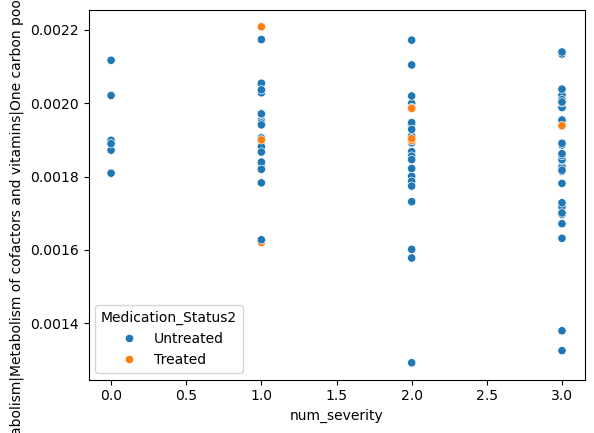

In [26]:
sns.scatterplot(y='Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate',x='num_severity',data=df,hue='Medication_Status2')

In [28]:
# dihydrofolate reductase (EC 1.5.1.3)
# Precorrin-6A reductase (EC 1.2.1.54)
queries = ['1.5.1.3]', '1.2.1.54]']
for p in p_to_KO:
    for q in queries:
        if q in p:
            print(p)
# p_to_KO

DHFR, folA; dihydrofolate reductase [EC:1.5.1.3]
folM; dihydromonapterin reductase / dihydrofolate reductase [EC:1.5.1.50 1.5.1.3]
dfrA1, dhfr; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrA12, dhfr; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrD, dhfr; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrA10, dfr10; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrA19, dfrA18; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrB, dfr2; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]


In [29]:
p_to_queries = {'B9': ['dihydrofolate reductase',
                      '5-formyltetrahydrofolate cyclo-ligase',
                      'tetrahydrofolate deformylase',
                      ##'N10 formyl'
                      ' homocysteine S-methyltransferase',
                        'hydroneopterin aldolase',
    'phosphoribosylglycinamide formyl',
    'dihydropteroate synthase', # might repeat with dihydroneopterin aldolase
    'deoxychorismate synthase',
 'S-adenosyl-L-methionine',
    'uroporphyrinogen III methyltransferase'
                      
                      ],
                'B12': ['precorrin-5B',
                       'sylcobinamide kinase',
                        'ribazoletransferase',
                    'methylmutase',
                    'sirohydrochlorin cobaltochelatase',
                    'onine-phosphate decarbox',
                    'cobalt-precorrin-4',
                    'denosylcobinamide-phosphate guanylyltransferase',
                   'cobinamide kinase',
                    'diamide synthase',
                    'precorrin-6B',
                    'precorrin-3B C17-methyltransferase',
                    'ribazole phosphatase',
                                        'precorrin-6A',
                    'precorrin-2 C20-methyltransferase'
                ],
               'ABC': ['Fe3+-transporting ATPase'],
               'Nonheme storage': ['ferritin',
                                   'Ferroxidase'],
               'Heme storage': ['uroporphyrinogen'],
               'Siderophore': ['nterobactin']}

p_to_p = {}

for p in ['ABC','Nonheme storage','Heme storage','Siderophore']:
# for p in p_to_queries: # e.g. B9
    #print('\n')
    #print('New Group: ' + p)
    p_to_p[p] = {}
    for t in p_to_queries[p]: # e.g. Dihydrofolate
        #print('Query: ' + t)
        #print('\n')
        p_to_p[p][t] = []
        for k in p_to_KO: # the entire database to KO mapping
            if t in k:
                p_to_p[p][t].append(k)
        if len(p_to_p[p][t]) == 0:
            print('No match:')
            print(t)
        else:
            #continue
            print('>= 1 match')
            print(p_to_p[p][t])



No match:
Fe3+-transporting ATPase
>= 1 match
['FTH1; ferritin heavy chain [EC:1.16.3.1]', 'bfd; bacterioferritin-associated ferredoxin', 'ftnA, ftn; ferritin [EC:1.16.3.2]', 'ftnB; ferritin-like protein 2', 'bfr; bacterioferritin [EC:1.16.3.1]', 'FTL; ferritin light chain', 'FTMT; ferritin, mitochondrial [EC:1.16.3.1]', 'bfrB; bacterioferritin B [EC:1.16.3.1]']
No match:
Ferroxidase
>= 1 match
['hemE, UROD; uroporphyrinogen decarboxylase [EC:4.1.1.37]', 'hemD, UROS; uroporphyrinogen-III synthase [EC:4.2.1.75]', 'cobA-hemD; uroporphyrinogen III methyltransferase / synthase [EC:2.1.1.107 4.2.1.75]', 'hemDX; uroporphyrinogen III methyltransferase / synthase [EC:2.1.1.107 4.2.1.75]']
>= 1 match
['entD, pptT; enterobactin synthetase component D / holo-[acyl-carrier protein] synthase [EC:6.3.2.14 2.7.8.7]', 'fes; iron(III)-enterobactin esterase [EC:3.1.1.108]', 'entS; MFS transporter, ENTS family, enterobactin (siderophore) exporter', 'iroC; ATP-binding cassette, subfamily B, salmochelin/en

In [30]:
# boxplots
df = pd.concat([df_med[['Diagnosis','Medication_Status2']],df_ko],axis=1)
df = rename_df(df,'Diagnosis')
df = df.rename(columns=KO_to_p)

dxs = df['Diagnosis'].unique()

corr_enz = []

for query in p_to_p: # query = B9, B12
    sketch_to_real = p_to_p[query] # sketch_to_real = dict mapping sketchy string like 'ydrofolate reduc' to list
    for sketch_v in sketch_to_real:
        int_v = p_to_p[query][sketch_v] # int_v = list of variables that can map to KOs
        #int_v = ['DHFR, folA; dihydrofolate reductase [EC:1.5.1.3]', 
        #     'cobK-cbiJ; precorrin-6A/cobalt-precorrin-6A reductase [EC:1.3.1.54 1.3.1.106]']
        for v in int_v:
            # print(v)
            #print(p_to_KO[v])

            try:
                k,p = scipy.stats.kruskal(*list(df.groupby('Diagnosis')[v].apply(list).values), 
                              nan_policy='propagate', axis=0, keepdims=False)

                plt.figure(figsize=(6,4))
                sns.stripplot(data=df,x='Diagnosis',y=v,hue='Medication_Status2',dodge=True)
                sns.boxplot(data=df,x='Diagnosis',y=v,hue='Medication_Status2',showfliers=False,legend=False)
                plt.savefig(path + 'outputs/jobs30/' + query + '_' + v.replace('/','_') + '_' + str(np.round(p,3)) + '.pdf')
                plt.close()

                corr_enz.append(v)
                
                '''
                comps = list(itertools.combinations(dxs, 2))
                for c in comps:
                c1,c2 = c
                r, p = scipy.stats.mannwhitneyu(df[df['Diagnosis'] == c1][v],df[df['Diagnosis'] == c2][v])
                if p < 0.05:
                print(c)
                print(p)
                '''
            except:
                print('not in data: ' + v)


not in data: FTH1; ferritin heavy chain [EC:1.16.3.1]
not in data: FTL; ferritin light chain
not in data: FTMT; ferritin, mitochondrial [EC:1.16.3.1]
not in data: bfrB; bacterioferritin B [EC:1.16.3.1]
not in data: iroC; ATP-binding cassette, subfamily B, salmochelin/enterobactin exporter
not in data: fepB; ferric enterobactin transport system substrate-binding protein
not in data: pfeE; iron(III)-enterobactin esterase [EC:3.1.1.108]
not in data: iroB; enterobactin C-glucosyltransferase [EC:2.4.1.369]


In [77]:
df_meta.columns.values

array(['BarcodeSequence', 'LinkerPrimerSequence', 'AmpliconWell', 'BSA',
       'BSASeverityByBSA', 'CCPtiter', 'CRP', 'CurrentBiologics',
       'CurrentIntralesionalSteroids', 'CurrentMTX', 'CurrentMTXdose',
       'CurrentOtherDMARDs', 'CurrentParenteralSteroids',
       'CurrentTopicalSteroids', 'CurrentUV', 'DAS28', 'Dactylitis',
       'DaysSinceExperimentStart', 'Diagnosis', 'DiseaseDuration',
       'DrugNaive', 'ESR', 'Enthesitis', 'ExampleMetaData', 'HLAB27',
       'Hispanic', 'HxBiologics', 'HxOtherDMARDs', 'MDHAQ',
       'NumberSamplePlate', 'PhysicianGlobalPsA', 'Plate',
       'ProbioticsInPast1mo', 'ProbioticsInPast3Months', 'Project',
       'PsAtype', 'PsOtype', 'RAPID3', 'RFtiter', 'Race', 'SJC',
       'Separate', 'SkinSwabCollected', 'SomeOtherInfo',
       'StoolCollectDate', 'StoolCollected', 'StoolReceivedDate', 'TJC',
       'TemplateDNAwell', 'Together', 'hxMTX', 'hxParenteralSteroids',
       'AliquotID', 'AliquotWeight', 'AliquotWeightUnit',
       'Specime

##### Scratch #####